In [1851]:
import yfinance as yf
import pandas as pd
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")


In [1852]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import unicodedata
from datetime import datetime, time, timedelta
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import ast

In [1853]:
# ==== BACA DATA ====
# List of stock tickers (Indonesian example)
# stocks = ["BBRI.JK", "BMRI.JK", "TLKM.JK"]
lq45_stocks = [
    "ACES.JK", "ADMR.JK", "ADRO.JK", "AKRA.JK", "AMMN.JK", "AMRT.JK", "ANTM.JK", "ARTO.JK", 
    "ASII.JK", "BBCA.JK", "BBNI.JK", "BBRI.JK", "BBTN.JK", "BMRI.JK", "BRIS.JK", "BRPT.JK", 
    "BUKA.JK", "CPIN.JK", "ESSA.JK", "EXCL.JK", "GOTO.JK", "ICBP.JK", "INCO.JK", "INDF.JK", 
    "INKP.JK", "INTP.JK", "ISAT.JK", "ITMG.JK", "JSMR.JK", "KLBF.JK", "MAPI.JK", "MBMA.JK", 
    "MDKA.JK", "MEDC.JK", "MTEL.JK", "PGAS.JK", "PGEO.JK", "PTBA.JK", "SIDO.JK", "SMGR.JK", 
    "SMRA.JK", "TLKM.JK", "TOWR.JK", "UNTR.JK", "UNVR.JK"
]


def get_stock_data(stock):
    """Fetch financial metrics, historical returns, and all closing prices with timestamps for a stock."""
    try:
        # Initialize ticker object
        stock_data = yf.Ticker(stock)

        # Fetch financials (ROA and ROE calculation)
        income_statement = stock_data.financials
        balance_sheet = stock_data.balance_sheet

        # Extract Net Income, Total Assets, and Shareholder's Equity
        net_income = income_statement.loc["Net Income"].iloc[0] if "Net Income" in income_statement.index else None
        total_assets = balance_sheet.loc["Total Assets"].iloc[0] if "Total Assets" in balance_sheet.index else None
        shareholders_equity = balance_sheet.loc['Stockholders Equity'].iloc[0] if 'Stockholders Equity' in balance_sheet.index else None

        roa = net_income / total_assets if total_assets else None
        roe = net_income / shareholders_equity if shareholders_equity else None

        # Fetch market capitalization
        market_cap = stock_data.info.get("marketCap", None)

        # Fetch historical data for returns calculation and closing prices
        hist_data = stock_data.history(period="1y")  # Last 1 year of data
        hist_data["Daily Return"] = hist_data["Close"].pct_change()

        mean_return = hist_data["Daily Return"].mean() if not hist_data["Daily Return"].isnull().all() else None
        variance_return = hist_data["Daily Return"].var() if not hist_data["Daily Return"].isnull().all() else None

        # Get all closing prices with timestamps
        closing_prices_with_timestamps = hist_data[["Close"]].reset_index()  # Reset index to include dates
        # Convert the 'Date' to the desired format 'Y-m-d'
        closing_prices_with_timestamps["Date"] = closing_prices_with_timestamps["Date"].dt.strftime('%Y-%m-%d')

        closing_prices_with_timestamps = closing_prices_with_timestamps[["Date", "Close"]].to_dict(orient='records')  # Convert to list of dicts

        if stock =='MEDC.JK':
            roa = 0.0510
            roe = 0.2169
        return {
            "Ticker": stock,
            "ROA": roa,
            "ROE": roe,  # Updated to include ROA, but you may need to replace with correct ROE
            "Market Cap": market_cap,
            "Mean Return": mean_return,
            "Variance Return": variance_return,
            "Closing Prices with Timestamps": closing_prices_with_timestamps,
        }
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")
        return {
            "Ticker": stock,
            "ROA": None,
            "ROE": None,
            "Market Cap": None,
            "Mean Return": None,
            "Variance Return": None,
            "Closing Prices with Timestamps": None,
        }

# Loop through all tickers and collect data
# results = [get_stock_data(stock) for stock in lq45_stocks]
# df = pd.DataFrame(results)
# df

# Optionally, save to CSV for future use:
# # df.to_csv("New_Data Saham dan Finansial LQ45.csv", index = False)


In [1854]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Menghitung 252 hari yang lalu dari hari ini
end_date = datetime.today()
start_date = end_date - timedelta(days=252)

# Format tanggal dalam format yang diterima oleh yfinance
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Fungsi untuk mendapatkan data saham
def get_stock_data(stock):
    try:
        # Inisialisasi objek ticker
        stock_data = yf.Ticker(stock)

        # Mengambil data historis untuk rentang waktu yang spesifik
        hist_data = stock_data.history(start=start_date_str, end=end_date_str)  # Data selama 252 hari

        # Menghitung return harian
        hist_data["Daily Return"] = hist_data["Close"].pct_change()

        mean_return = hist_data["Daily Return"].mean() if not hist_data["Daily Return"].isnull().all() else None
        variance_return = hist_data["Daily Return"].var() if not hist_data["Daily Return"].isnull().all() else None

        # Mendapatkan harga penutupan dengan timestamp
        closing_prices_with_timestamps = hist_data[["Close"]].reset_index()  # Reset index untuk memasukkan tanggal
        closing_prices_with_timestamps["Date"] = closing_prices_with_timestamps["Date"].dt.strftime('%Y-%m-%d')

        closing_prices_with_timestamps = closing_prices_with_timestamps[["Date", "Close"]].to_dict(orient='records')  # Mengubah menjadi list of dicts

        # Mengambil data keuangan dan metrik lainnya
        income_statement = stock_data.financials
        balance_sheet = stock_data.balance_sheet

        net_income = income_statement.loc["Net Income"].iloc[0] if "Net Income" in income_statement.index else None
        total_assets = balance_sheet.loc["Total Assets"].iloc[0] if "Total Assets" in balance_sheet.index else None
        shareholders_equity = balance_sheet.loc['Stockholders Equity'].iloc[0] if 'Stockholders Equity' in balance_sheet.index else None

        roa = net_income / total_assets if total_assets else None
        roe = net_income / shareholders_equity if shareholders_equity else None

        # Mengambil kapitalisasi pasar
        market_cap = stock_data.info.get("marketCap", None)
        if stock =='MEDC.JK':
            roa = 0.0510
            roe = 0.2169
        return {
            "Ticker": stock,
            "ROA": roa,
            "ROE": roe,
            "Market Cap": market_cap,
            "Mean Return": mean_return,
            "Variance Return": variance_return,
            "Closing Prices with Timestamps": closing_prices_with_timestamps,
        }
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")
        return {
            "Ticker": stock,
            "ROA": None,
            "ROE": None,
            "Market Cap": None,
            "Mean Return": None,
            "Variance Return": None,
            "Closing Prices with Timestamps": None,
        }

# Mengambil data untuk seluruh saham
# results = [get_stock_data(stock) for stock in lq45_stocks]

# # Membuat dataframe dari hasilnya
# df = pd.DataFrame(results)

# # Menampilkan hasil
# print(df)


In [1855]:
data = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
# data = df.copy()
data.set_index("Ticker", inplace=True)
data.drop(['Closing Prices with Timestamps'], axis = 1, inplace = True)
data.head()

,ROA,ROE,Market Cap,Mean Return,Variance Return
Ticker,,,,,
ACES.JK,0.098476,0.124282,13182707957760,0.000655,0.000534
ADMR.JK,0.260126,0.451713,53555809484800,0.000354,0.000646
ADRO.JK,0.156735,0.242362,71052591890432,0.002643,0.000822
AKRA.JK,0.091898,0.246865,25658361118720,0.000129,0.000345
AMMN.JK,0.027717,0.055417,683483982725120,0.001989,0.000777


In [1856]:
scaler = StandardScaler()
df_scaled1 = pd.DataFrame(scaler.fit_transform(data), columns = scaler.get_feature_names_out(), index = data.index)
df_scaled = df_scaled1.drop(['ROA'], axis = 1)

7746, 7523

rand 5098 bagus kalo 252

In [1857]:
rnd = np.random.randint(0, 10000)
print(rnd)

2335


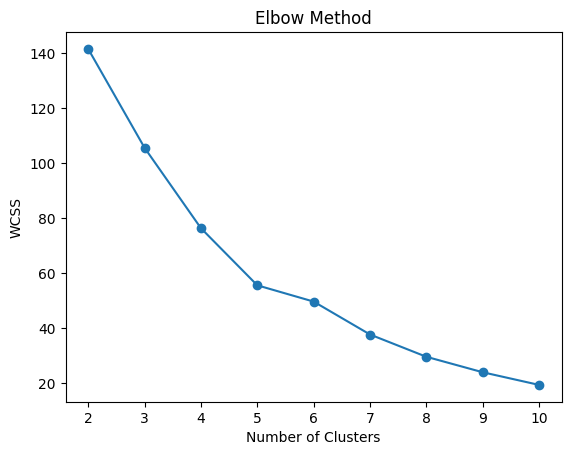

In [1858]:
wcss = []

# Specify the range of cluster numbers to try
num_clusters_range = range(2, 11)

# Perform K-Means clustering for different numbers of clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=rnd)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(num_clusters_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

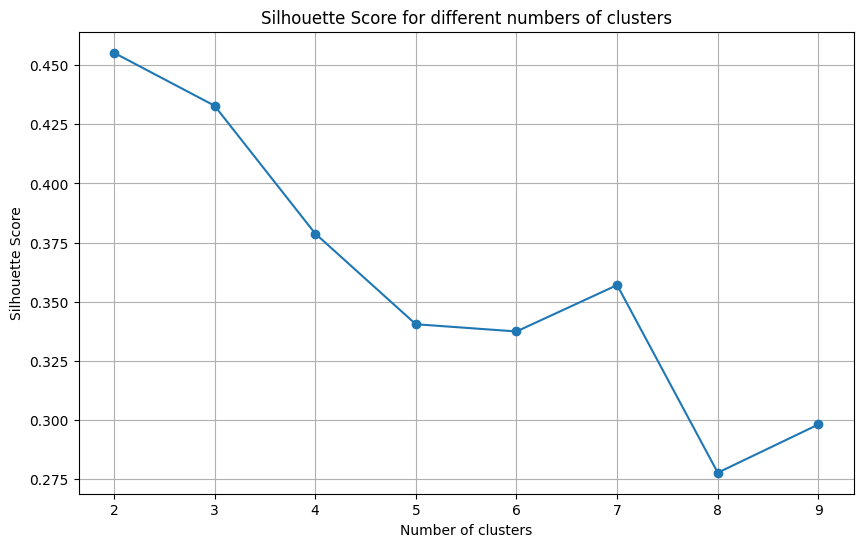

In [1859]:
silhouette_scores = []
cluster_range = range(2, 10)  # Ubah range ini sesuai kebutuhan Anda

for n_clusters in cluster_range:
    km_cluster = KMeans(n_clusters = n_clusters, random_state = rnd)
    cluster_labels = km_cluster.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 4. Plot Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [1860]:

kmeans_cluster = KMeans(n_clusters = 3,random_state=rnd)
cluster_labels = kmeans_cluster.fit_predict(df_scaled)

# 4. Calculate Evaluation Metrics
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
davies_bouldin_avg = davies_bouldin_score(df_scaled, cluster_labels)
calinski_harabasz_avg = calinski_harabasz_score(df_scaled, cluster_labels)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_avg}')

# 5. Add cluster labels to the original DataFrame (optional)
data['Cluster'] = cluster_labels

Silhouette Score: 0.4329069355976914
Davies-Bouldin Index: 1.2116538101524514
Calinski-Harabasz Index: 14.8383282112269


In [1861]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   
BRIS.JK  0.016129  0.147235  137004020924416     0.002639         0.000720   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK        0      0.097624  
AMMN.JK        1      0.062818  
BRIS.JK        2      0.089507  


# Cluster Analysis

In [1862]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

In [1863]:
df_final = df_scaled1.drop(['ROA'], axis = 1)
df_final.head()

,ROE,Market Cap,Mean Return,Variance Return
Ticker,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084
ADMR.JK,0.778213,-0.325757,0.133485,0.311211
ADRO.JK,0.293330,-0.248688,2.254371,0.823429
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337
AMMN.JK,-0.139658,2.448907,1.647973,0.691505


# KMeans

In [1864]:
# Opsional: Tuning parameter eps dan min_samples
df_kme = df_final.copy()

# GMM
kmeans = KMeans(n_clusters = 3, random_state = 7523)
kmeans.fit(df_kme)
labelg = kmeans.predict(df_kme)

unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_kme, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_kme, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_kme, labelg)}')

df_kme['cluster'] = labelg
data['Cluster'] = labelg

# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)


print(df_kme.cluster.value_counts())
df_kme.head()

Clusters present: [0 1 2]
Clusters sizes: [26 15  4] 

Silhouette Score: 0.1876610631591391
Calinski-Harabasz Index: 11.726280359577002
Davies-Bouldin Index: 1.2225726311316092
              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
ADMR.JK  0.260126  0.451713   53555809484800     0.000354         0.000646   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   

         Cluster  sharpe_ratio  
Ticker                          
ADMR.JK        0      0.004564  
PGAS.JK        1      0.097624  
AMMN.JK        2      0.062818  
cluster
0    26
1    15
2     4
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,1
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,0
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,1
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,2


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

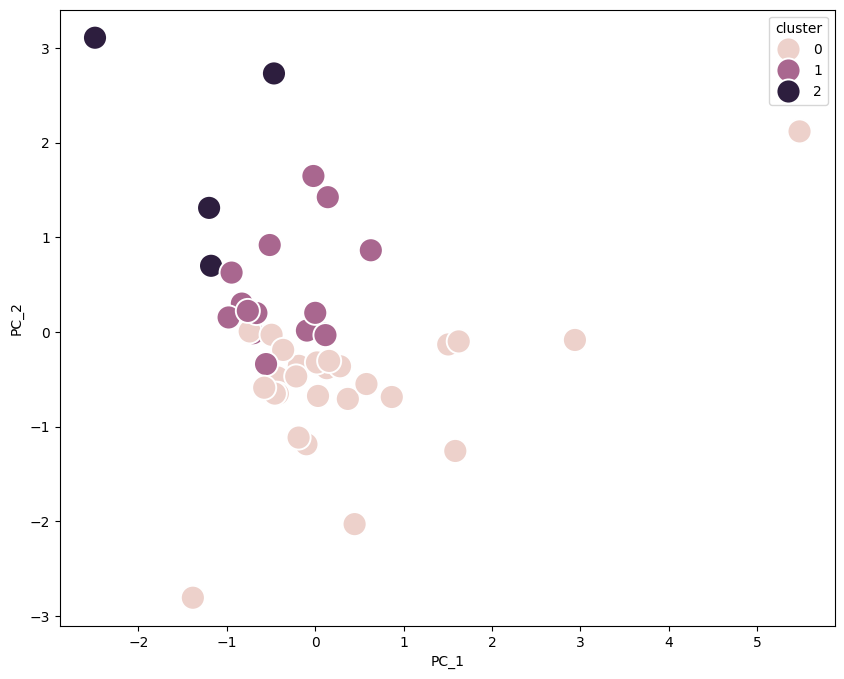

In [1865]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_kme.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_kme.index)

df_pca2 = pd.concat([df_pca2, df_kme.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [1866]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_kme.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_kme.index)

df_pca_3 = pd.concat([df_pca_3, df_kme.cluster], axis = 1)
# df_pca1.head()

In [1867]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,0.081060,-0.011719,-0.645003,1
ADMR.JK,-0.185258,-0.358235,-0.417066,0
ADRO.JK,0.141843,1.422983,-1.696032,1
AKRA.JK,-0.427134,-0.481004,-0.351792,0
AMMN.JK,-0.467157,2.729693,0.706150,2


In [1868]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# Gaussian Mixture

In [1952]:
# Opsional: Tuning parameter eps dan min_samples
df_gmm = df_final.copy()

rand = np.random.randint(0, 10000)
print(rand)
# GMM
gmm = GaussianMixture(n_components = 2, random_state=2383)
gmm.fit(df_gmm)
labelg = gmm.predict(df_gmm)

# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_gmm, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_gmm, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_gmm, labelg)}')

df_gmm['cluster'] = labelg
data['Cluster'] = labelg

print(df_gmm.cluster.value_counts())
df_gmm.head()

8300
              ROA       ROE      Market Cap  Mean Return  Variance Return  \
Ticker                                                                      
PGAS.JK  0.042140  0.103040  38422777430016     0.002017         0.000332   
GOTO.JK -1.670984 -2.383206  91717776703488    -0.000042         0.001415   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK        0      0.097624  
GOTO.JK        1     -0.007451  
Clusters present: [0 1]
Clusters sizes: [43  2] 

Silhouette Score: 0.5924471320543033
Calinski-Harabasz Index: 12.542834656651449
Davies-Bouldin Index: 0.9222398843404966
cluster
0    43
1     2
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,0
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,0
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,0


In [1871]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
UNTR.JK  0.133818  0.260084  100964321198080     0.001568         0.000246   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
GOTO.JK -1.670984 -2.383206   91717776703488    -0.000042         0.001415   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   

         Cluster  sharpe_ratio  
Ticker                          
UNTR.JK        0      0.084842  
PGAS.JK        1      0.097624  
GOTO.JK        2     -0.007451  
AMMN.JK        3      0.062818  


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

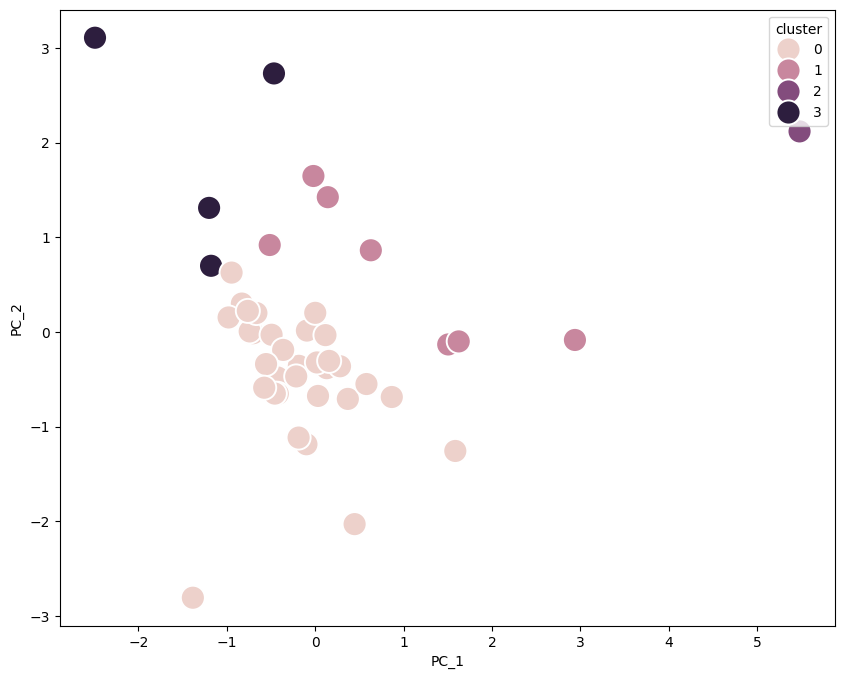

In [1795]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_gmm.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_gmm.index)

df_pca2 = pd.concat([df_pca2, df_gmm.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [1796]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_gmm.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_gmm.index)

df_pca_3 = pd.concat([df_pca_3, df_gmm.cluster], axis = 1)
# df_pca1.head()

In [1797]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,0.081060,-0.011719,-0.645003,0
ADMR.JK,-0.185258,-0.358235,-0.417066,0
ADRO.JK,0.141843,1.422983,-1.696032,1
AKRA.JK,-0.427134,-0.481004,-0.351792,0
AMMN.JK,-0.467157,2.729693,0.706150,3


In [1798]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# OPTICS

In [1799]:
import numpy as np
import pandas as pd
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming df_final is your DataFrame with features for clustering
df_optics = df_final.copy()

# Apply OPTICS clustering
optics = OPTICS(min_samples=10, xi=0.0001, min_cluster_size=0.0000001)
optics.fit(df_optics)

# Extract labels and number of clusters
labels = optics.labels_

# Calculate metrics
unique_labels = np.unique(labels)
n_clusters_formed = len(unique_labels) - (1 if -1 in labels else 0)
print(f'Clusters present: {unique_labels}')
print(f'Number of clusters formed: {n_clusters_formed}')
print(f'Clusters sizes: {np.bincount(labels + 1)}', '\n')  # +1 to include noise as a category

# Calculate and print clustering evaluation metrics, excluding noise
non_noise_indices = labels != -1
if n_clusters_formed > 1:  # Metrics are meaningful when there is more than one cluster
    print(f'Silhouette Score: {silhouette_score(df_optics[non_noise_indices], labels[non_noise_indices])}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_optics[non_noise_indices], labels[non_noise_indices])}')
    print(f'Davies-Bouldin Index: {davies_bouldin_score(df_optics[non_noise_indices], labels[non_noise_indices])}')
else:
    print("Not enough clusters formed for meaningful evaluation metrics.")

# Add cluster labels to the DataFrame
df_optics['cluster'] = labels
data['Cluster'] = labels

# Show the cluster counts
print(df_optics['cluster'].value_counts())
df_optics.head()


Clusters present: [0]
Number of clusters formed: 1
Clusters sizes: [ 0 45] 

Not enough clusters formed for meaningful evaluation metrics.
cluster
0    45
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,0
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,0
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,0


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

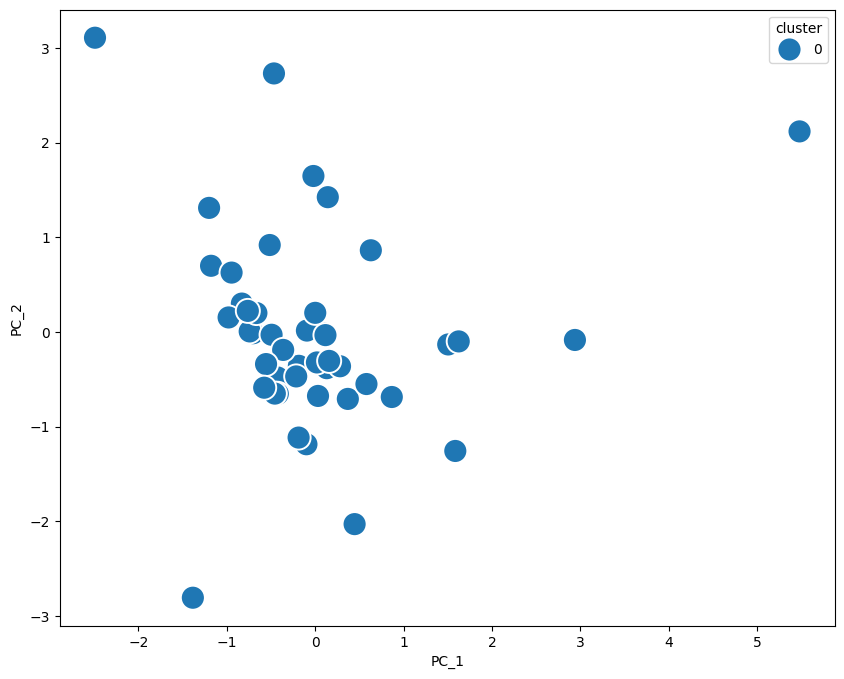

In [1800]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_optics.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_optics.index)

df_pca2 = pd.concat([df_pca2, df_optics.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

In [1801]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_optics.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_optics.index)

df_pca_3 = pd.concat([df_pca_3, df_optics.cluster], axis = 1)
# df_pca1.head()

# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# # klaster 3
# Cluster2= go.Scatter3d(
#         x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
#         y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
#         z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
#         mode="markers",
#         marker=dict(
#                     size=10,
#                     color="rgb(0,0,255)",
#         ),
#         name="Cluster 2"
# )
# klaster noise
Cluster3= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==-1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==-1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==-1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,225,0)",
        ),
        name="Cluster Noise"
)

data_plot_km=[Cluster0,Cluster1,Cluster3]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# BIRCH

In [1802]:
import numpy as np
import pandas as pd
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming df_final is your DataFrame with features for clustering
df_birch = df_final.copy()

# Apply BIRCH clustering
birch = Birch(n_clusters=3)
birch.fit(df_birch)

# Extract labels
labels = birch.labels_

# Calculate metrics
unique_labels = np.unique(labels)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Number of clusters formed: {n_clusters_formed}')
print(f'Clusters sizes: {np.bincount(labels)}', '\n')

# Calculate and print clustering evaluation metrics
print(f'Silhouette Score: {silhouette_score(df_birch, labels)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_birch, labels)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_birch, labels)}')

# Add cluster labels to the DataFrame
df_birch['cluster'] = labels
data['Cluster'] = labels

# Show the cluster counts
print(df_birch['cluster'].value_counts())
df_birch.head()


Clusters present: [0 1 2]
Number of clusters formed: 3
Clusters sizes: [40  1  4] 

Silhouette Score: 0.48052274695254366
Calinski-Harabasz Index: 16.54532989280959
Davies-Bouldin Index: 0.6401671062935425
cluster
0    40
2     4
1     1
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,0
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,0
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,2


In [1803]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
GOTO.JK -1.670984 -2.383206   91717776703488    -0.000042         0.001415   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK        0      0.097624  
GOTO.JK        1     -0.007451  
AMMN.JK        2      0.062818  


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

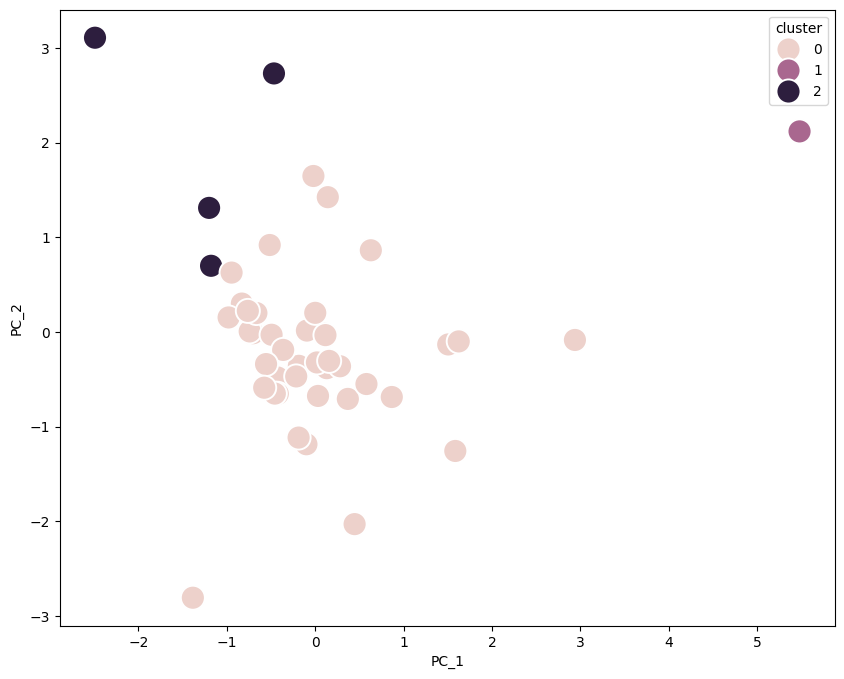

In [1804]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_birch.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_birch.index)

df_pca2 = pd.concat([df_pca2, df_birch.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

In [1805]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_birch.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_birch.index)

df_pca_3 = pd.concat([df_pca_3, df_birch.cluster], axis = 1)
# df_pca1.head()

# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)
data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# Spectral Clustering

Explained variance by PCA: 65.00%


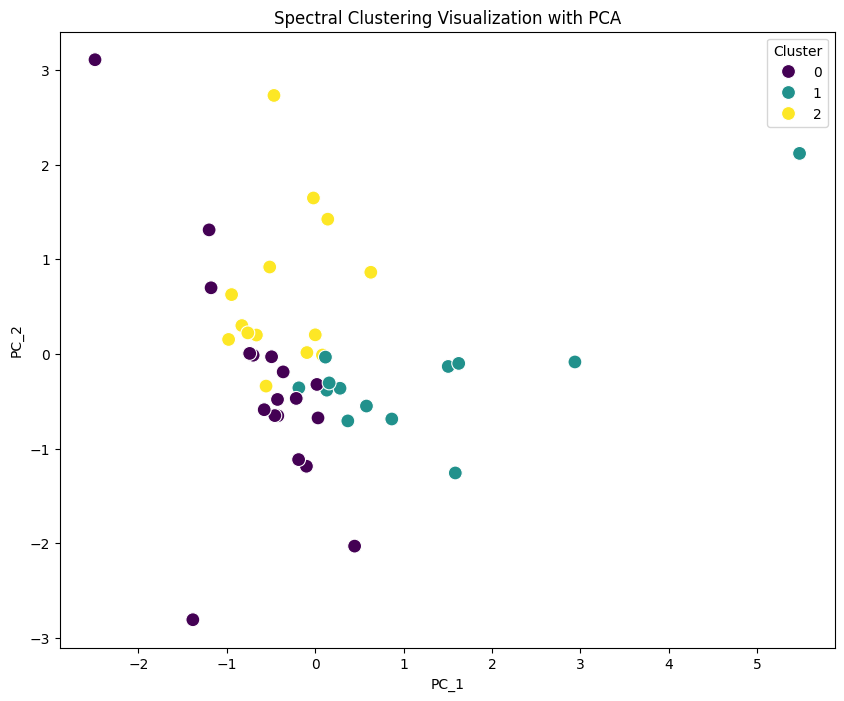

Cluster: cluster
0    18
2    14
1    13
Name: count, dtype: int64
Calinski-Harabasz Index: 8.618646744779376
Silhouette Score: 0.16104534633834555
Davies-Bouldin Index: 1.4992310435923872


In [1806]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Assuming df_final is your DataFrame with features for clustering
df_spec = df_final.copy()
X_std = df_final.copy().values  # Convert DataFrame to NumPy array

# Apply Spectral Clustering
n_clusters = 3  # Specify the number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
labels = spectral.fit_predict(X_std)

# Add cluster labels to DataFrame
df_spec['cluster'] = labels
data['Cluster'] = labels

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:, :-1]),
                      columns=['PC_1', 'PC_2'],
                      index=df_spec.index)

df_pca2 = pd.concat([df_pca2, df_spec['cluster']], axis=1)

# Print the explained variance ratio
print(f"Explained variance by PCA: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data=df_pca2, x='PC_1', y='PC_2', hue='cluster', palette='viridis', s=100, ax=ax)
plt.title('Spectral Clustering Visualization with PCA')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.legend(title='Cluster')
plt.show()

# Compute and print clustering evaluation metrics
print(f'Cluster: {df_spec['cluster'].value_counts()}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(X_std, labels)}')
print(f'Silhouette Score: {silhouette_score(X_std, labels)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(X_std, labels)}')


In [1807]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE        Market Cap  Mean Return  Variance Return  \
Ticker                                                                        
BBCA.JK  0.034542  0.200693  1241995691425792     0.000782         0.000194   
MEDC.JK  0.051000  0.216900    27071927549952     0.000651         0.000627   
PGAS.JK  0.042140  0.103040    38422777430016     0.002017         0.000332   

         Cluster  sharpe_ratio  
Ticker                          
BBCA.JK        0      0.039002  
MEDC.JK        1      0.016501  
PGAS.JK        2      0.097624  


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

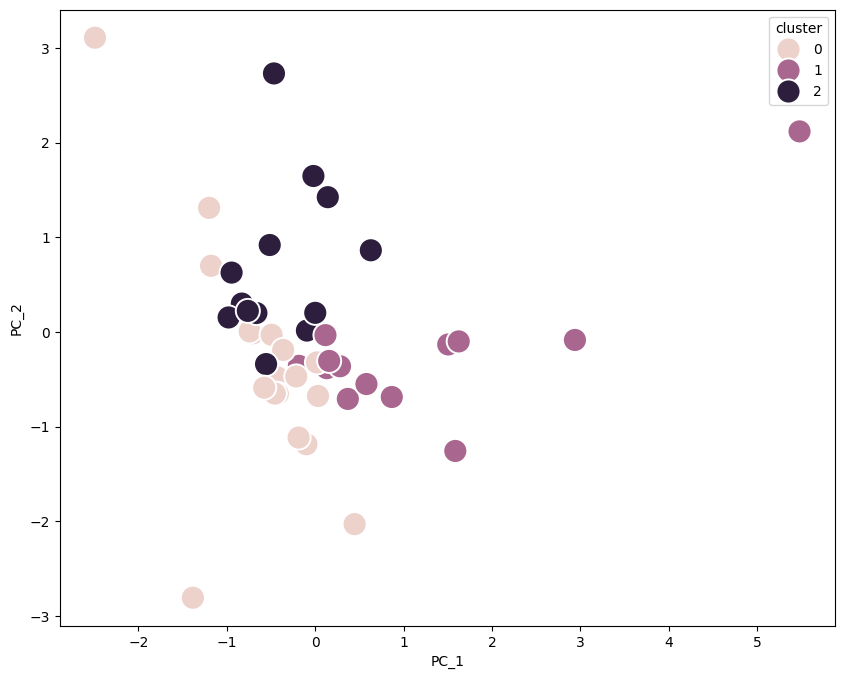

In [1808]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_spec.index)

df_pca2 = pd.concat([df_pca2, df_spec.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [1809]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_spec.index)

df_pca_3 = pd.concat([df_pca_3, df_spec.cluster], axis = 1)
# df_pca1.head()

In [1810]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,0.081060,-0.011719,-0.645003,2
ADMR.JK,-0.185258,-0.358235,-0.417066,1
ADRO.JK,0.141843,1.422983,-1.696032,2
AKRA.JK,-0.427134,-0.481004,-0.351792,0
AMMN.JK,-0.467157,2.729693,0.706150,2


In [1811]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# Agglomerative

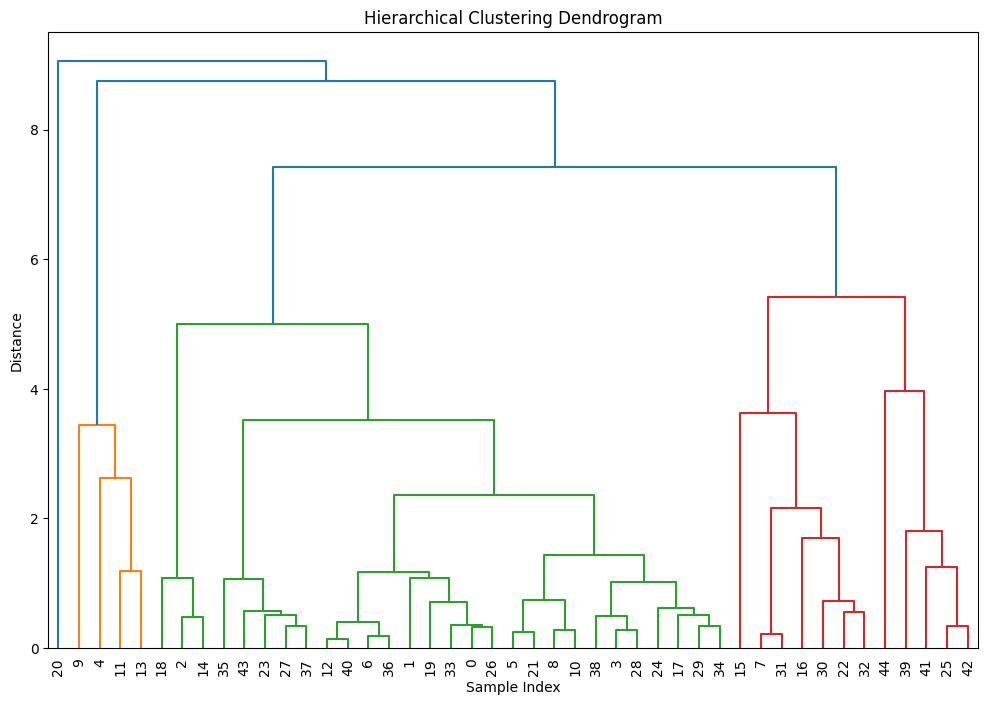

In [1812]:
# Assuming df_std is your standardized DataFrame
df_agl1 = df_final.copy()

# Apply Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=1)
labelagl1 = agglomerative.fit_predict(df_agl1)
df_agl1['cluster'] = labelagl1

# Compute the linkage matrix
linkage_matrix = linkage(df_agl1.drop(columns=['cluster']), method='ward')

# Plot the dendrogram with all data points
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [1813]:
df_agl = df_final.copy()

agglomerative = AgglomerativeClustering(n_clusters=4, metric = 'euclidean',linkage='ward')
labelagl = agglomerative.fit_predict(df_agl)

# Periksa apakah terdapat cluster yang terbentuk
unique_labels = np.unique(labelagl)
n_clusters_formed = len(unique_labels)
if n_clusters_formed > 1:  # Cek apakah terdapat lebih dari satu klaster yang terbentuk
    score = silhouette_score(df_agl, labelagl)
    print(f'Clusters present: {unique_labels}')
    print(f'Clusters sizes: {np.bincount(labelagl)}', '\n')
    print(f'Silhouette Score: {silhouette_score(df_agl, labelagl)}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_agl, labelagl)}')
    print(f'Davies-Bouldin Index: {davies_bouldin_score(df_agl, labelagl)}')
else:
    print("Tidak ada klaster yang terbentuk dengan parameter ini.\n")

df_agl['cluster'] = labelagl
data['Cluster'] = labelagl

Clusters present: [0 1 2 3]
Clusters sizes: [12 28  4  1] 

Silhouette Score: 0.3343121078999996
Calinski-Harabasz Index: 19.952803194274182
Davies-Bouldin Index: 0.9281229919362145


In [1814]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
ARTO.JK  0.003398  0.008659   36721051828224    -0.000005         0.001129   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   
GOTO.JK -1.670984 -2.383206   91717776703488    -0.000042         0.001415   

         Cluster  sharpe_ratio  
Ticker                          
ARTO.JK        0     -0.007232  
PGAS.JK        1      0.097624  
AMMN.JK        2      0.062818  
GOTO.JK        3     -0.007451  


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

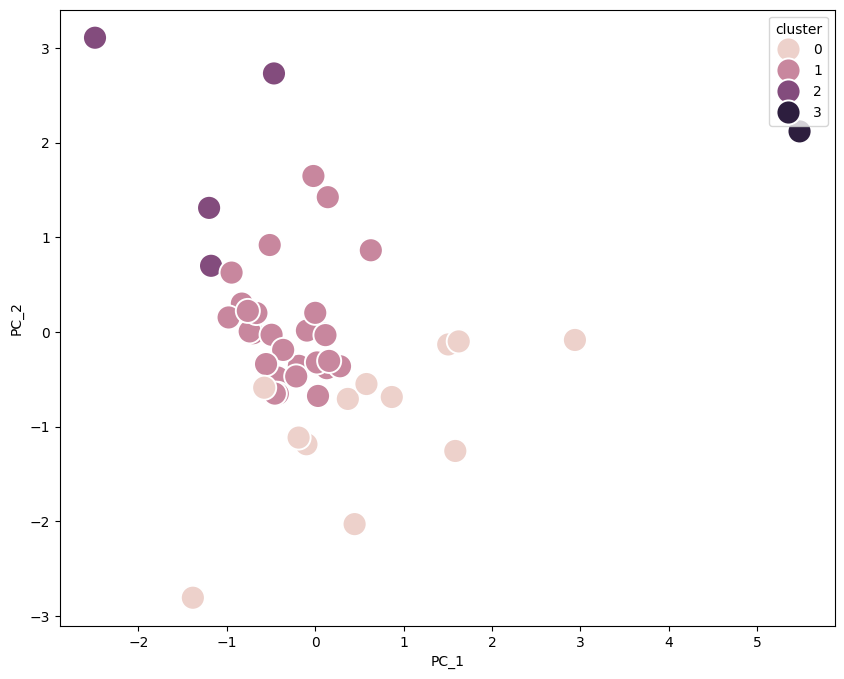

In [1815]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_agl.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_agl.index)

df_pca2 = pd.concat([df_pca2, df_agl.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [1816]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_agl.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_agl.index)

df_pca_3 = pd.concat([df_pca_3, df_agl.cluster], axis = 1)
# df_pca1.head()

In [1817]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,0.081060,-0.011719,-0.645003,1
ADMR.JK,-0.185258,-0.358235,-0.417066,1
ADRO.JK,0.141843,1.422983,-1.696032,1
AKRA.JK,-0.427134,-0.481004,-0.351792,1
AMMN.JK,-0.467157,2.729693,0.706150,2


In [1818]:
# membuat visualisasi 3D untuk setiap klaster

# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

In [1819]:
df_agl

,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,1
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,1
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,1
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,1
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,2
AMRT.JK,0.276663,-0.000140,0.214998,-0.718876,1
ANTM.JK,-0.035391,-0.406057,-0.210453,-0.078249,1
ARTO.JK,-0.247955,-0.399909,-0.199115,1.716608,0
ASII.JK,0.126549,0.347773,-0.112428,-0.815975,1


# DBSCAN

In [1820]:
# Opsional: Tuning parameter eps dan min_samples
df_dbs = df_final.copy()

# GMM
dbs = DBSCAN()
dbs.fit(df_dbs)
labelg = dbs.labels_

unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
# print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_dbs, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_dbs, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_dbs, labelg)}')

df_dbs['cluster'] = labelg
data['Cluster'] = labelg

print(df_dbs.cluster.value_counts())
df_dbs.head()

Clusters present: [-1  0]
Silhouette Score: 0.0712689834820442
Calinski-Harabasz Index: 1.710340172463659
Davies-Bouldin Index: 3.4038621292169404
cluster
-1    27
 0    18
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,-1
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,-1
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,-1


In [1821]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE      Market Cap  Mean Return  Variance Return  \
Ticker                                                                      
PGAS.JK  0.042140  0.103040  38422777430016     0.002017         0.000332   
ISAT.JK  0.039281  0.146569  81272013586432     0.000728         0.000563   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK       -1      0.097624  
ISAT.JK        0      0.020657  


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

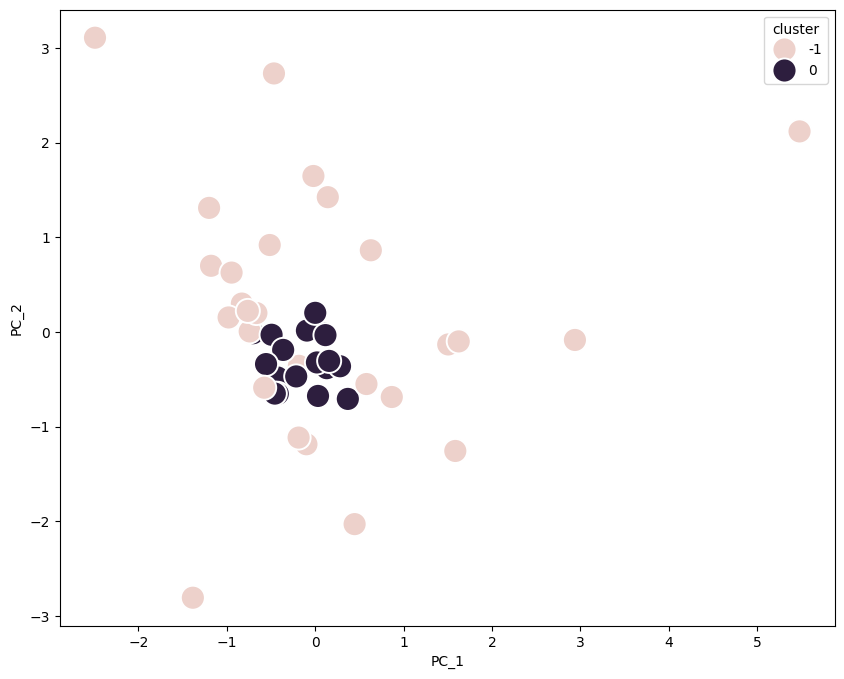

In [1822]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_dbs.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_dbs.index)

df_pca2 = pd.concat([df_pca2, df_dbs.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [1823]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_spec.index)

df_pca_3 = pd.concat([df_pca_3, df_spec.cluster], axis = 1)
# df_pca1.head()

In [1824]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,0.081060,-0.011719,-0.645003,2
ADMR.JK,-0.185258,-0.358235,-0.417066,1
ADRO.JK,0.141843,1.422983,-1.696032,2
AKRA.JK,-0.427134,-0.481004,-0.351792,0
AMMN.JK,-0.467157,2.729693,0.706150,2


In [1825]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# Cek asumsi portfolio terpilih dengan KMeans

In [1826]:
# Opsional: Tuning parameter eps dan min_samples
df_kme = df_final.copy()

# GMM
random_state_value = np.random.randint(0, 10000)

kmeans = KMeans(n_clusters = 3, random_state = 5098)
print(random_state_value)
kmeans.fit(df_kme)
labelg = kmeans.predict(df_kme)

unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_kme, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_kme, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_kme, labelg)}')

df_kme['cluster'] = labelg
data['Cluster'] = labelg

# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)


print(df_kme.cluster.value_counts())

320
Clusters present: [0 1 2]
Clusters sizes: [ 4 36  5] 

Silhouette Score: 0.4640177656249543
Calinski-Harabasz Index: 16.57620566042255
Davies-Bouldin Index: 0.9719186427710209
              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
ARTO.JK  0.003398  0.008659   36721051828224    -0.000005         0.001129   

         Cluster  sharpe_ratio  
Ticker                          
AMMN.JK        0      0.062818  
PGAS.JK        1      0.097624  
ARTO.JK        2     -0.007232  
cluster
1    36
2     5
0     4
Name: count, dtype: int64


In [1827]:
# Opsional: Tuning parameter eps dan min_samples
df_kme = df_final.copy()

# GMM
random_state_value = np.random.randint(0, 10000)

kmeans = KMeans(n_clusters = 4, random_state = 7746)
print(random_state_value)
kmeans.fit(df_kme)
labelg = kmeans.predict(df_kme)

unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_kme, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_kme, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_kme, labelg)}')

df_kme['cluster'] = labelg
data['Cluster'] = labelg

# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)


print(df_kme.cluster.value_counts())

1588
Clusters present: [0 1 2 3]
Clusters sizes: [17 23  4  1] 

Silhouette Score: 0.2217813920782776
Calinski-Harabasz Index: 13.323682312466934
Davies-Bouldin Index: 1.107593148975228
              ROA       ROE        Market Cap  Mean Return  Variance Return  \
Ticker                                                                        
BBCA.JK  0.034542  0.200693  1241995691425792     0.000782         0.000194   
PGAS.JK  0.042140  0.103040    38422777430016     0.002017         0.000332   
ARTO.JK  0.003398  0.008659    36721051828224    -0.000005         0.001129   
GOTO.JK -1.670984 -2.383206    91717776703488    -0.000042         0.001415   

         Cluster  sharpe_ratio  
Ticker                          
BBCA.JK        0      0.039002  
PGAS.JK        1      0.097624  
ARTO.JK        2     -0.007232  
GOTO.JK        3     -0.007451  
cluster
1    23
0    17
2     4
3     1
Name: count, dtype: int64


In [1828]:
def semideviation(r):
    # Compute the semideviation of a return series.
    is_negetive= r<0
    return np.std(r[is_negetive], ddof=0, axis=0)

def var_historic(r,level= 5):
    # Compute the historic Value-at-Risk of a return series.
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

def cvar_historic(r,level=5):
    # Compute the historic Conditional Value-at-Risk of a return series.
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
    

def skewness(r):
    # Compute the skewness of a return series.
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    skewness = exp / sigma_r**3
    return skewness

def kurtosis(r):
    # Compute the kurtosis of a return series.
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    kurtosis = exp / sigma_r**4
    return kurtosis

def is_normal(r,level =0.01, alternative = 'two-sided'):
    # Apply the Jarque-Bera test to determine if a return series is normal.
    statistic, p_value = ss.kstest(r, 'norm', args=(np.mean(r), np.std(r)))
    if alternative == 'two-sided':
        return p_value
    elif alternative == 'greater':
        return p_value > level / 2
    elif alternative == 'less':
        return p_value < level / 2
    else:
        raise ValueError("Invalid alternative hypothesis")
    
import numpy as np
import scipy.stats as ss

def goodness_of_fit(data1, dist, level=0.01, alternative='two-sided'):
    data = -data1
    """
    Apply the Kolmogorov-Smirnov test to determine goodness of fit for a given distribution.

    Parameters:
    - data: array-like, the sample data to test.
    - dist: str, the distribution name ('t', 'lognorm', 'gev').
    - level: float, significance level for the test.
    - alternative: str, 'two-sided', 'greater', or 'less'.

    Returns:
    - p_value: float, the p-value of the test.
    - result: bool, whether the null hypothesis (data follows the given distribution) is rejected.
    """
    # Estimate distribution parameters
    if dist == 't':
        params = ss.t.fit(data)
        cdf = lambda x: ss.t.cdf(x, *params)
    elif dist == 'lognorm':
        params = ss.lognorm.fit(data, floc=0)  # Lognormal distribution with location fixed to 0
        cdf = lambda x: ss.lognorm.cdf(x, *params)
    elif dist == 'gev':
        params = ss.genextreme.fit(data)
        cdf = lambda x: ss.genextreme.cdf(x, *params)
    else:
        raise ValueError("Invalid distribution name. Choose 't', 'lognorm', or 'gev'.")

    # Perform KS test
    statistic, p_value = ss.kstest(data, cdf, alternative=alternative)

    # Determine if null hypothesis is rejected
    if alternative == 'two-sided':
        result = p_value < level
    elif alternative == 'greater':
        result = p_value < level / 2
    elif alternative == 'less':
        result = p_value < level / 2
    else:
        raise ValueError("Invalid alternative hypothesis")

    return p_value

In [1829]:
def summary_stats(r):
    # caviar_result, model_summary = calculate_caviar(r, quantile=0.05)
    # Compute summary statistics for a return series.
    stats = {
        "Mean": r.mean(),
        "Median": r.median(),
        "Variance": r.var(),
        "Standard Deviation": r.std(),
        "Normality": is_normal(r,level =0.05, alternative = 'two-sided'),
        "Student-t": goodness_of_fit(r, 't'),
        # "Log Normal": goodness_of_fit(r, 'lognorm'),
        "GEV": goodness_of_fit(r, 'gev'),
        "Skewness": skewness(r),
        "Kurtosis": kurtosis(r),
        # "Semideviation": semideviation,
        # "VaR (5%)": var_historic(r, level=5),
        # "CVaR (5%)": cvar_historic(r, level=5),
        # "CAViaR (5%)": caviar_result['VaR_Prediction'].tail(1).values[0],
    }
    return pd.Series(stats)

In [1872]:
data_df = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
# data_df = df.copy()
data_df.head()

,Ticker,ROA,ROE,Market Cap,Mean Return,Variance Return,Closing Prices with Timestamps
0,ACES.JK,0.098476,0.124282,13182707957760,0.000655,0.000534,"[{'Date': '2023-12-06', 'Close': 701.563964843..."
1,ADMR.JK,0.260126,0.451713,53555809484800,0.000354,0.000646,"[{'Date': '2023-12-06', 'Close': 1300.0}, {'Da..."
2,ADRO.JK,0.156735,0.242362,71052591890432,0.002643,0.000822,"[{'Date': '2023-12-06', 'Close': 1362.95568847..."
3,AKRA.JK,0.091898,0.246865,25658361118720,0.000129,0.000345,"[{'Date': '2023-12-06', 'Close': 1313.31225585..."
4,AMMN.JK,0.027717,0.055417,683483982725120,0.001989,0.000777,"[{'Date': '2023-12-06', 'Close': 6425.0}, {'Da..."


In [1876]:
# Pilih ticker tertentu
selected_tickers = ["AMMN.JK", "UNTR.JK", "PGAS.JK"]

# Filter data berdasarkan ticker tertentu
filtered_df = data_df[data_df["Ticker"].isin(selected_tickers)]

# Buat DataFrame baru untuk menyimpan data harga penutupan
closing_prices = pd.DataFrame()

# Iterasi setiap baris untuk mengekstrak harga penutupan
for index, row in filtered_df.iterrows():
    ticker = row["Ticker"]
    prices = pd.DataFrame(ast.literal_eval(row["Closing Prices with Timestamps"]))  # Konversi ke DataFrame
    prices.set_index("Date", inplace=True)  # Set index menjadi Date
    prices = prices.rename(columns={"Close": ticker})  # Rename kolom menjadi nama ticker
    closing_prices = pd.concat([closing_prices, prices], axis=1)  # Gabungkan data

# Hasil akhir
closing_prices


,AMMN.JK,PGAS.JK,UNTR.JK
Date,,,
2023-12-06,6425.0,1020.066467,19710.476562
2023-12-07,6475.0,1001.931946,19778.835938
2023-12-08,6450.0,1001.931946,20325.716797
2023-12-11,6825.0,1001.931946,19892.771484
2023-12-12,7000.0,988.331055,19915.556641
...,...,...,...
2024-12-02,9025.0,1570.000000,27400.000000
2024-12-03,9350.0,1585.000000,27150.000000
2024-12-04,9575.0,1595.000000,27625.000000


In [1875]:
# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(closing_prices.index, closing_prices['BRPT.JK'], label=f'Harga Penutupan', color='green')

# Add labels and title
plt.title('Harga Penutupan Saham ...')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

KeyError: 'BRPT.JK'

<Figure size 1000x600 with 0 Axes>

In [1878]:
returns_df = closing_prices.pct_change() * 100
returns_df = returns_df.dropna()
returns_df

,AMMN.JK,PGAS.JK,UNTR.JK
Date,,,
2023-12-07,0.778210,-1.777778,0.346817
2023-12-08,-0.386100,0.000000,2.764980
2023-12-11,5.813953,0.000000,-2.130037
2023-12-12,2.564103,-1.357467,0.114540
2023-12-13,1.785714,-0.917425,-4.233411
...,...,...,...
2024-12-02,0.277778,3.289474,2.334267
2024-12-03,3.601108,0.955414,-0.912409
2024-12-04,2.406417,0.630915,1.749540


In [1879]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the histogram using seaborn
sns.histplot(closing_prices['BRPT.JK'], kde=True)

# Add title and labels
plt.title('Histogram of Return')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

KeyError: 'BRPT.JK'

In [1880]:
summary_stats(returns_df['AMMN.JK'])
#ADRO.JK	AMMN.JK	INDF.JK

Mean                   0.198888
Median                 0.000000
Variance               7.767905
Standard Deviation     2.787096
Normality              0.060673
Student-t              0.481714
GEV                    0.001750
Skewness               1.408136
Kurtosis              13.271400
dtype: float64

In [1881]:
summary_stats(returns_df["UNTR.JK"])

Mean                  0.156802
Median                0.105258
Variance              2.457119
Standard Deviation    1.567520
Normality             0.201318
Student-t             0.786991
GEV                   0.066533
Skewness              0.097376
Kurtosis              3.944033
dtype: float64

In [1882]:
summary_stats(returns_df['PGAS.JK'])

Mean                  0.201693
Median                0.000000
Variance              3.320109
Standard Deviation    1.822117
Normality             0.059168
Student-t             0.338449
GEV                   0.002122
Skewness              0.873409
Kurtosis              9.313761
dtype: float64